# Clustering via Gausian Mixtures

In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

file_path_ISOMap_raw = "../../reduced_data/joueurs_ligue1_ISOMap_raw.csv"
file_path_ISOMap_per90 = "../../reduced_data/joueurs_ligue1_ISOMap_per90.csv"

data_ISOMap_raw = pd.read_csv(file_path_ISOMap_raw, encoding="utf-8")
data_ISOMap_per90 = pd.read_csv(file_path_ISOMap_per90, encoding="utf-8")
print(data_ISOMap_raw.head(1))

    isomap_1  isomap_2  isomap_3  isomap_4  isomap_5  isomap_6  isomap_7  \
0  21.062129 -4.222008 -2.173427 -3.796018 -2.686983  4.300071   2.18389   

     player_name  equipe positions  
0  Jordan Lefort  Angers        DF  


## Data Preparation : standardisation + columns removal

In [17]:
X_iso_raw = data_ISOMap_raw.drop(columns=['player_name', 'equipe', 'positions']).copy()
X_iso_per90 = data_ISOMap_per90.drop(columns=['player_name', 'equipe', 'positions']).copy()

scaler = StandardScaler()
X_iso_raw = scaler.fit_transform(X_iso_raw) 
X_iso_per90 = scaler.fit_transform(X_iso_per90)
print(X_iso_raw[1])

[ 1.34474033  1.30283802 -2.32940855  1.67514762  2.58475243  0.03916205
  0.59423857]


## GridSearch Analysis

In [12]:
def gmm_gridsearch(X, n_components_range=range(2, 8), cov_types=['full','tied','diag','spherical'], random_state=42, verbose=True):
    results = []

    for n in n_components_range:
        for cov in cov_types:
            gmm = GaussianMixture(n_components=n, covariance_type=cov, random_state=random_state)
            gmm.fit(X)
            labels = gmm.predict(X)

            bic = gmm.bic(X)
            aic = gmm.aic(X)
            #resposabilites = gmm.predict_proba(X)
            convergence = gmm.converged_

            try:
                sil_score = silhouette_score(X, labels)
                db_score = davies_bouldin_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)
            except Exception as e:
                sil_score = np.nan
                db_score = np.nan
                ch_score = np.nan

            results.append({
                'n_components': n,
                'covariance_type': cov,
                'BIC': bic,
                'AIC': aic,
                'silhouette_score': sil_score,
                'davies_bouldin': db_score,
                'calinski_harabasz': ch_score,
                #'resposabilites': resposabilites,
                'converged': convergence
            })

    results_df = pd.DataFrame(results)

    metrics = ['BIC', 'AIC', 'silhouette_score', 'davies_bouldin', 'calinski_harabasz']
    pivot_df = results_df.pivot(index='n_components', columns='covariance_type')[metrics]

    flat_df = pivot_df.swaplevel(axis=1).sort_index(axis=1)
    flat_df.columns = [f"{cov}_{metric}" for cov, metric in flat_df.columns]

    # Classements sur chaque indicateur
    rank_df = pd.DataFrame(index=flat_df.index)

    for col in flat_df.columns:
        metric = col.split("_", 1)[1]
        if metric in ['BIC', 'AIC', 'davies_bouldin']:
            rank_df[col] = flat_df[col].rank(method='min', ascending=True)
        else:
            rank_df[col] = flat_df[col].rank(method='min', ascending=False)

    # Moyenne qualité de modélisation (AIC + BIC)
    model_cols = [col for col in rank_df.columns if 'AIC' in col or 'BIC' in col]
    rank_df['mean_model_score'] = rank_df[model_cols].mean(axis=1)

    # Moyenne qualité de clustering (silhouette + db + ch)
    cluster_cols = [col for col in rank_df.columns if any(m in col for m in ['silhouette', 'davies', 'calinski'])]
    rank_df['mean_cluster_score'] = rank_df[cluster_cols].mean(axis=1)

    # Moyenne par covariance type
    covariance_scores = {}
    for cov in cov_types:
        cov_cols = [col for col in rank_df.columns if col.startswith(cov)]
        covariance_scores[cov] = rank_df[cov_cols].mean().mean()  # moyenne sur toutes les lignes

    covariance_df = pd.Series(covariance_scores).sort_values()

    # Affichage
    print("\n📊 Classements individuels (par combinaison n_components x covariance):")
    print(rank_df[['mean_model_score', 'mean_cluster_score']])

    print("\n📈 Moyenne des classements par type de covariance (tous n_components confondus):")
    print(covariance_df)

    return results_df, rank_df


gmm_results_per90 = gmm_gridsearch(X_iso_per90, n_components_range=range(2,25), cov_types=['full'], random_state=42)




📊 Classements individuels (par combinaison n_components x covariance):
              mean_model_score  mean_cluster_score
n_components                                      
2                         14.5           15.333333
3                         12.5           16.666667
4                         11.5            8.333333
5                         10.0           19.000000
6                         12.5           11.666667
7                         10.5            5.333333
8                          6.5            7.000000
9                          8.5           15.666667
10                         7.0           14.666667
11                         9.0           12.666667
12                        12.5           14.000000
13                        13.5           16.000000
14                        11.5            8.000000
15                        13.5            8.333333
16                        13.0           10.333333
17                        11.5            9.000000
18        

## Run Gaussian mixtures

In [15]:
def run_gmm(X, data, n_clusters, random_state=42, covariance_type='full'):
    gmm = GaussianMixture(n_components=n_clusters, covariance_type=covariance_type, random_state=random_state)
    gmm.fit(X)
    labels = gmm.predict(X)

    df = pd.DataFrame(X, columns=[f'isomap_{i+1}' for i in range(X.shape[1])])
    df["cluster"] = labels

    meta_cols = ['player_name', 'equipe', 'positions']
    df_meta = data[meta_cols].copy()
    df_meta.index = df.index 
    df = df_meta.join(df)
    
    return df, gmm

X_gmm_iso_raw, gmm_iso_raw = run_gmm(X_iso_raw, data_ISOMap_raw, n_clusters = 8, covariance_type = "full", random_state = 42)
X_gmm_iso_per90, gmm_iso_per90 = run_gmm(X_iso_raw, data_ISOMap_raw, n_clusters = 7, covariance_type = "full", random_state = 42)

## Results Display

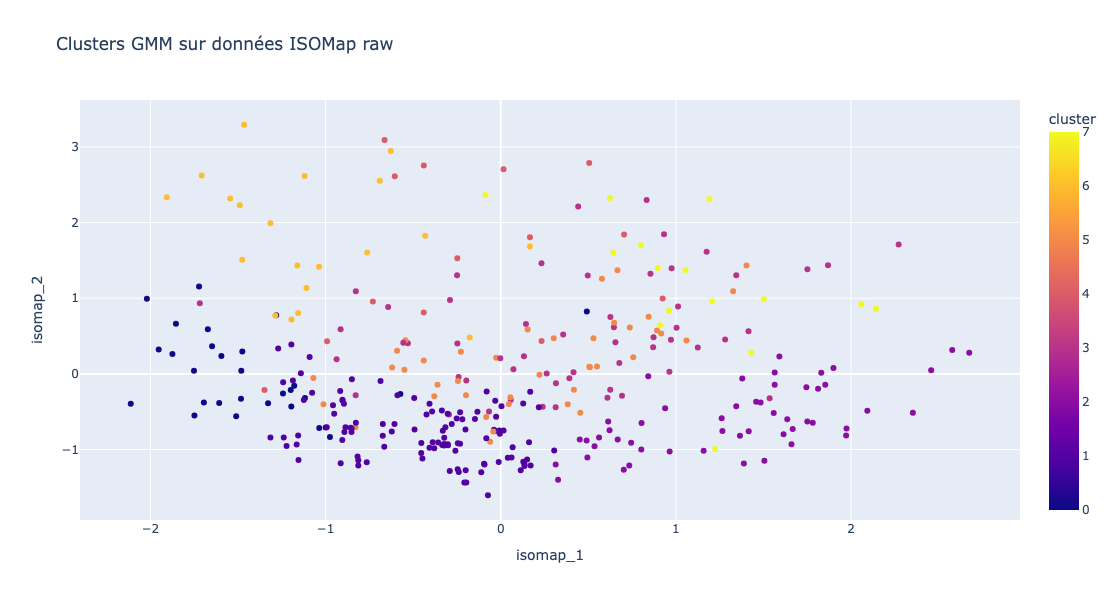

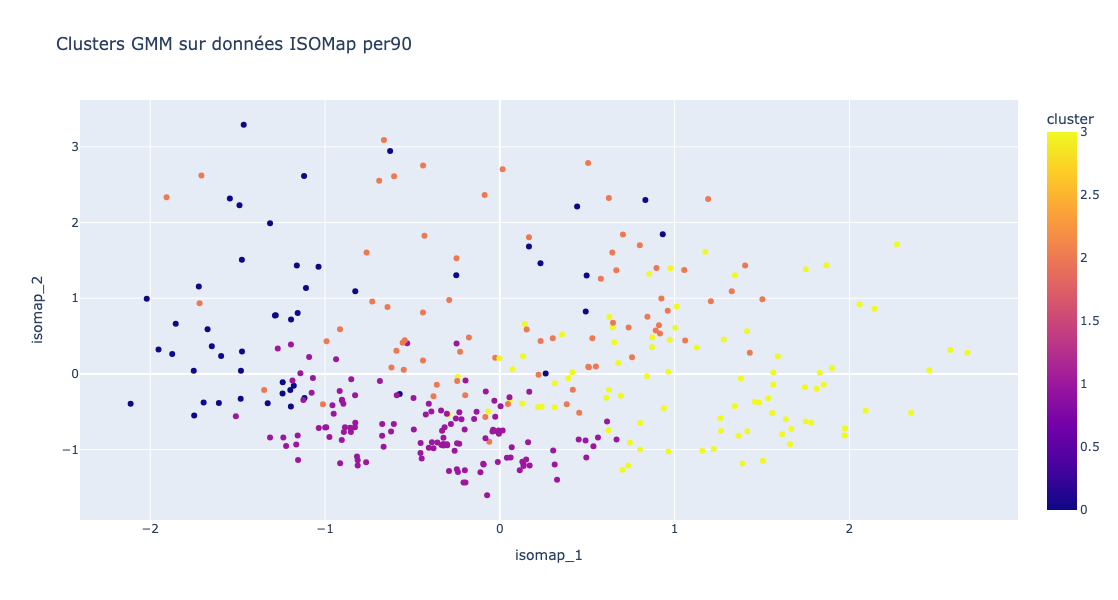

In [14]:
def print_results(X, column1, column2, data_name) :
    fig = px.scatter(
        X,
        x= column1, 
        y= column2, 
        color='cluster', 
        hover_data=['player_name', 'positions'],  # ce qui s'affiche au survol
        title=f"Clusters GMM sur données {data_name}",
        width=800, 
        height=600,
        color_discrete_sequence= None
    )
    fig.show()

print_results(X_gmm_iso_raw, "isomap_1", "isomap_2", "ISOMap raw")
print_results(X_gmm_iso_per90, "isomap_1", "isomap_2", "ISOMap per90")